In [1]:
library(fma)
library(fpp)
library(forecast)

Loading required package: tseries
Loading required package: forecast
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: expsmooth
Loading required package: lmtest


## 2a) Describe Series

There is trend and seasonality in this data.
The Seasonplot shows that Q1 & Q2 are fairly steady, but there is a decrease in Q3. Then back up in Q4.
The YOY trend is mostly up in the large middle section. Had a bad few years in early 2000, but it is slowly recovering.

As it looks right now, we will probably want to use the Holt-Winters model and put a highish number on Alpha to use the more recent observations. Probably have a fairly strong number on the seaonality too.

In [2]:
ds_full = ukcars
start(ukcars)
end(ukcars)

[1] 1977    1

[1] 2005    1

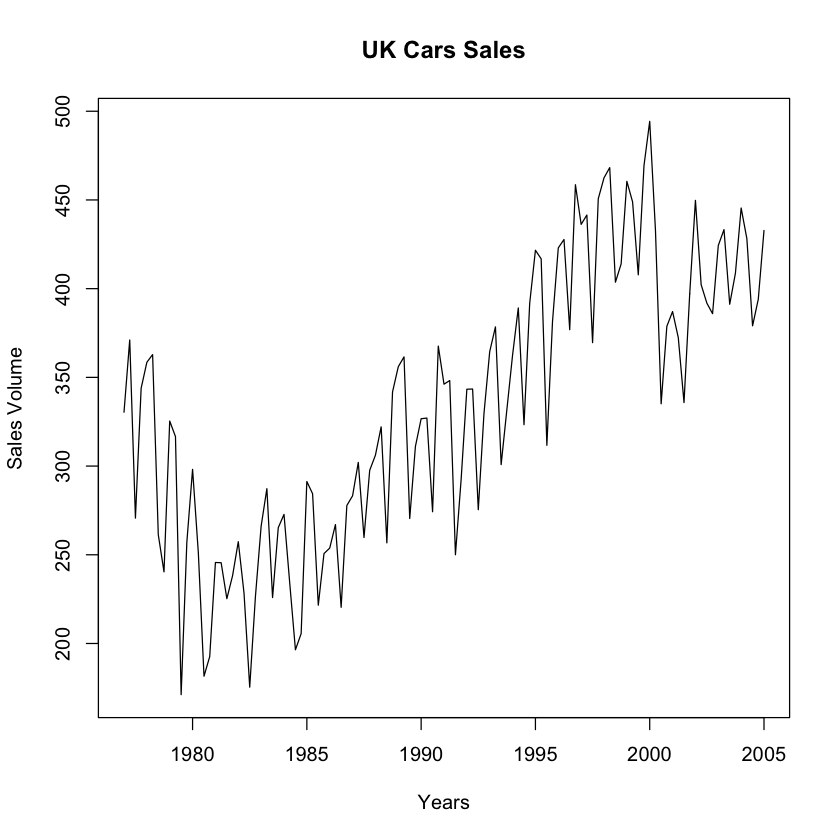

In [3]:
plot(ds_full, main="UK Cars Sales", xlab="Years", ylab="Sales Volume")

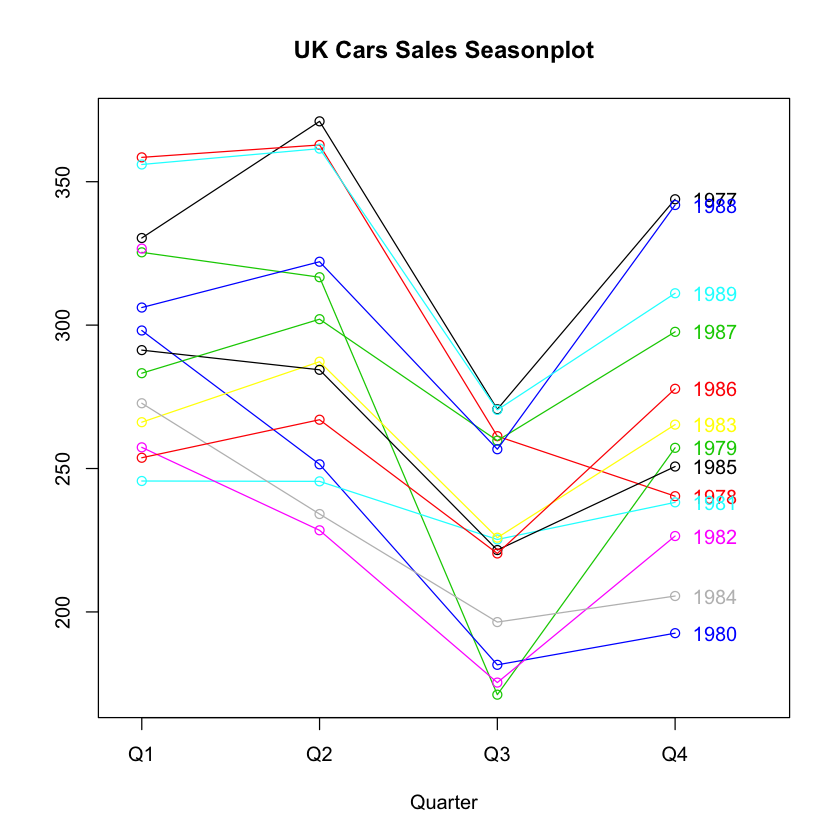

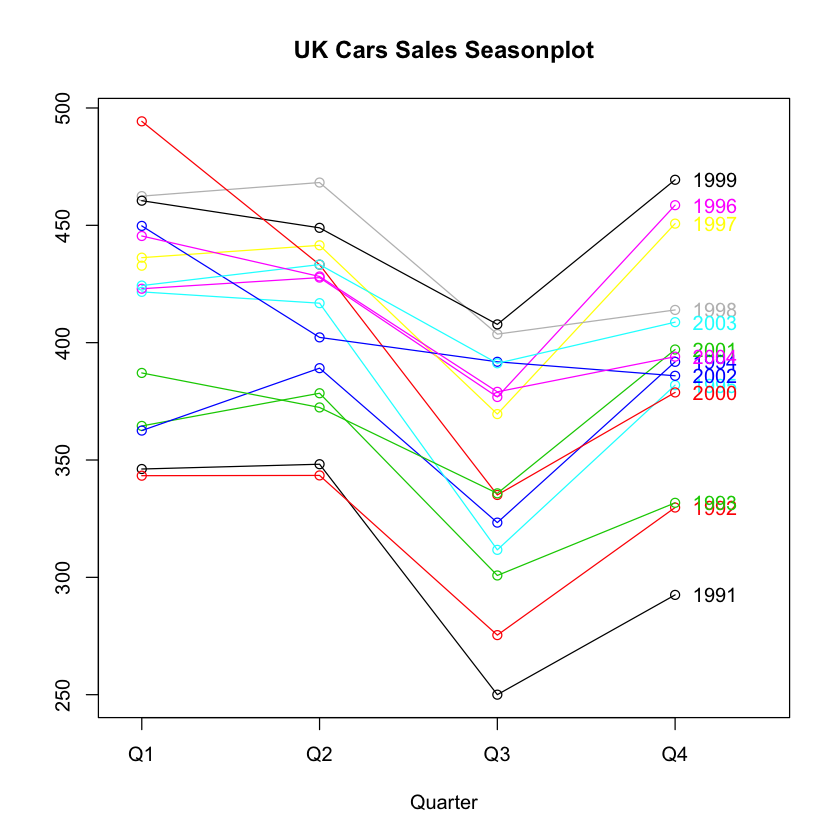

In [4]:
numyears = end(ds_full)[1] - start(ds_full)[1]
seasonplot(window(ds_full, start=1977, end=1990), year.labels=TRUE, col=1:14, main="UK Cars Sales Seasonplot")
seasonplot(window(ds_full, start=1991, end=2005), year.labels=TRUE, col=1:15, main="UK Cars Sales Seasonplot")

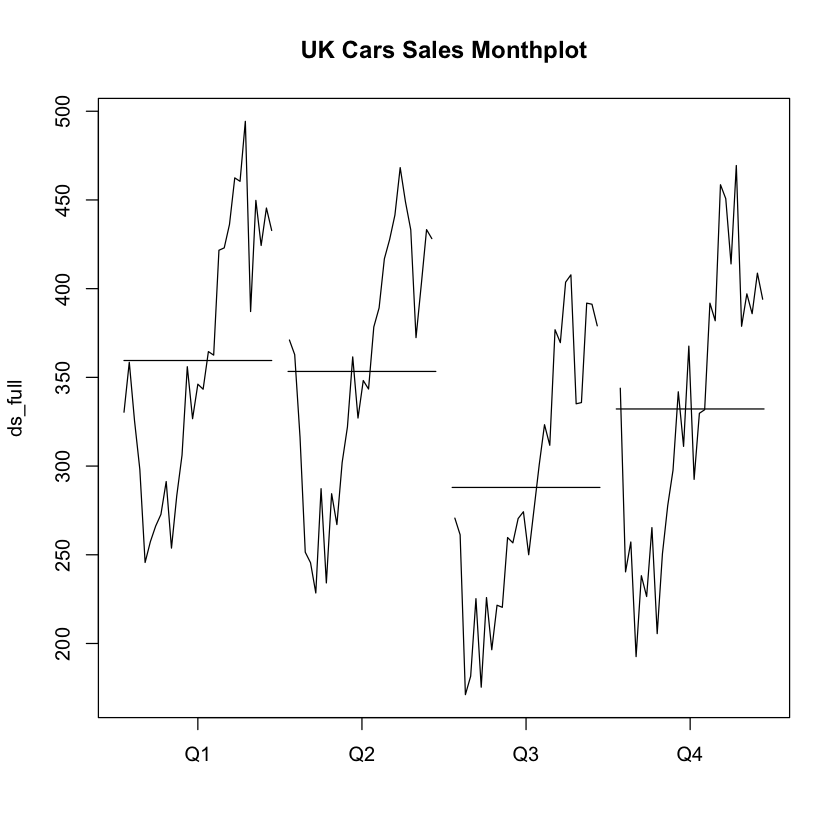

In [5]:
monthplot(ds_full, main="UK Cars Sales Monthplot")

## 2b) STL

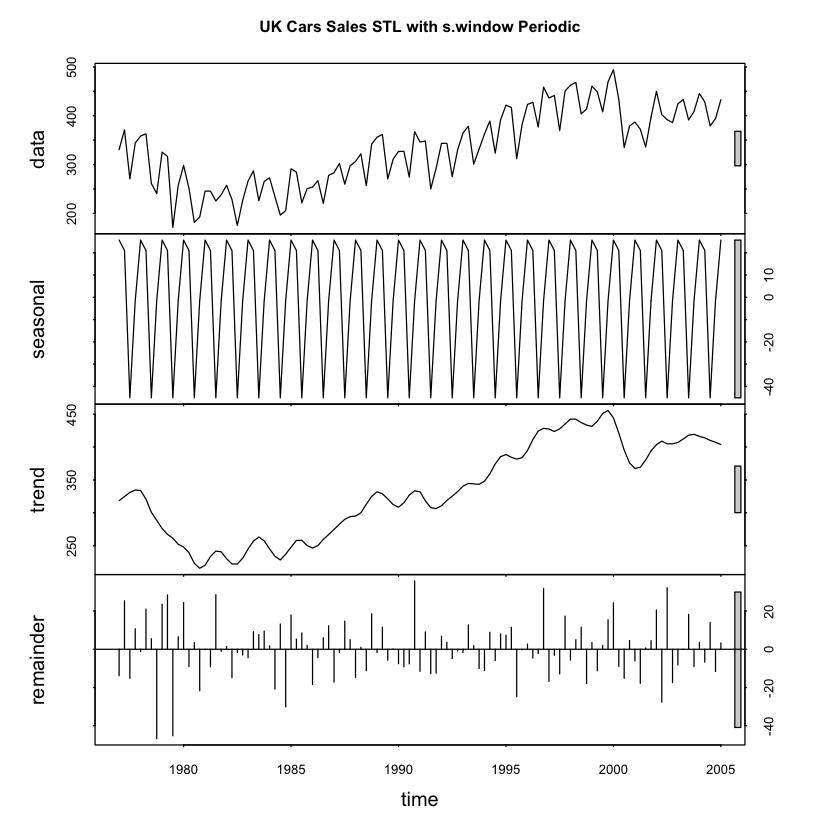

In [6]:
ds_stl = stl(ds_full, s.window="periodic")
plot(ds_stl, main="UK Cars Sales STL with s.window Periodic")

## 2b) Seasonally Adjusted Data

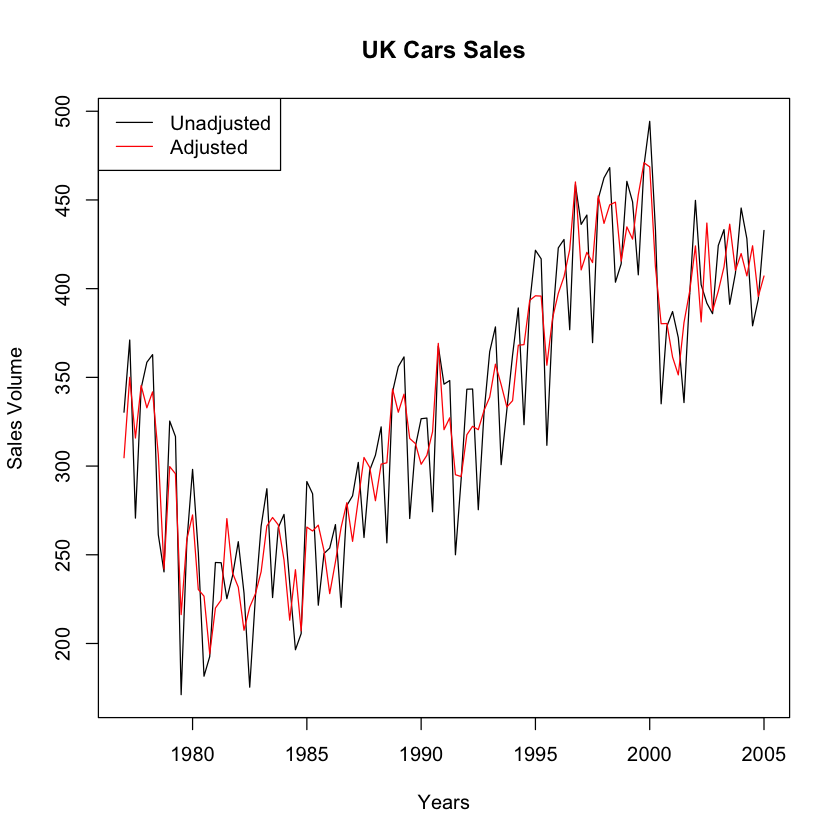

In [7]:
ds_sa = seasadj(ds_stl)

plot(ds_full, main="UK Cars Sales", ylab="Sales Volume", xlab="Years")
lines(ds_sa, col="red")
legend("topleft", legend=c('Unadjusted', 'Adjusted'), col=c("black", "red"), lty=c(1,1))

## 2c) Forecast

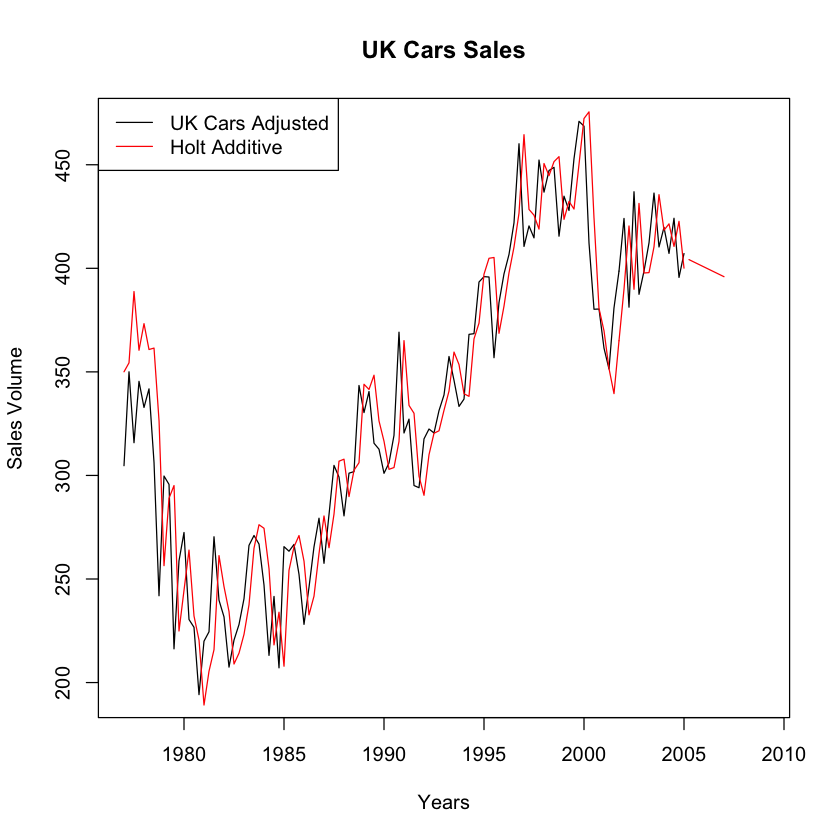

In [8]:
# Holt Linear Model
holt_lin = holt(ds_sa, h=8, initial="simple")

plot(ds_sa, xlim=c(start(ukcars)[1], end(ukcars)[1]+4), main="UK Cars Sales", ylab="Sales Volume", xlab="Years")
abline(a=0, b=0)

# Plot the fitted values to original
lines(fitted(holt_lin), col="red")
# Plot the forecasted values
lines(holt_lin$mean, col="red")

legend("topleft"
       , lty=1
       , col=c("black", "red")
       , c("UK Cars Adjusted", "Holt Additive")
       )

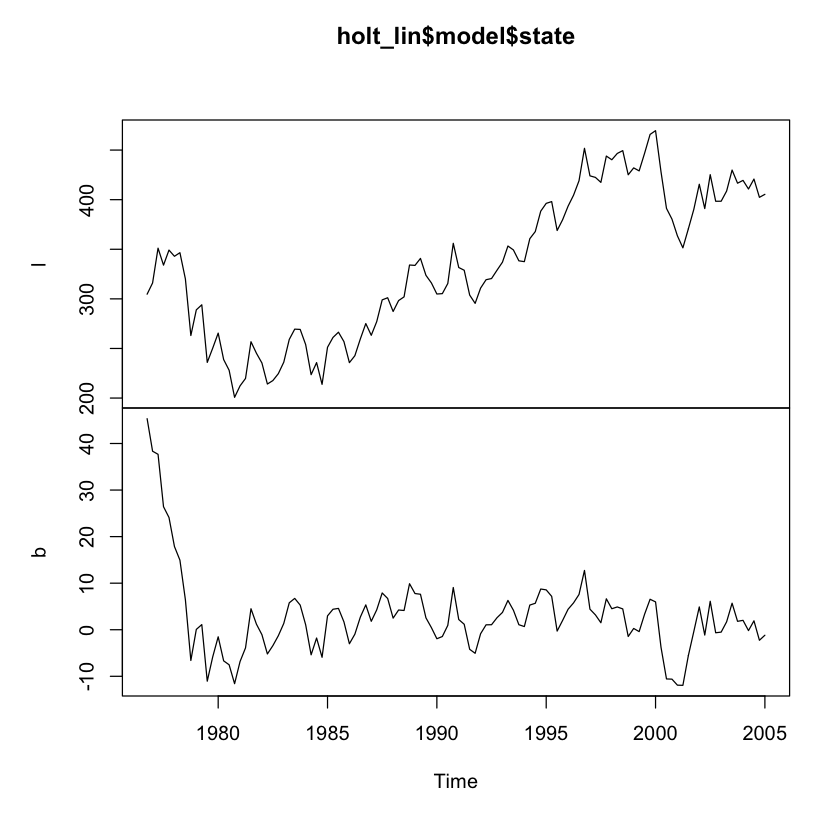

In [9]:
plot(holt_lin$model$state)

## 2d) Summarize Model

alpha is fairly large so it determined to weight the more recent observations

beta is fairly small so it using earlier observations to smooth out the trend

In [18]:
summary(holt_lin)


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = ds_sa, h = 8, initial = "simple") 

  Smoothing parameters:
    alpha = 0.7505 
    beta  = 0.2054 

  Initial states:
    l = 304.7042 
    b = 45.3325 

  sigma:  28.7024
Error measures:
                    ME     RMSE      MAE      MPE     MAPE      MASE
Training set -2.669845 28.70238 22.50912 -1.16915 7.324064 0.7335612
                     ACF1
Training set -0.008396094

Forecasts:
        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2005 Q2       404.1974 367.4138 440.9810 347.9418 460.4530
2005 Q3       403.0201 346.6475 459.3926 316.8057 489.2344
2005 Q4       401.8427 326.3092 477.3762 286.3242 517.3613
2006 Q1       400.6654 305.5363 495.7945 255.1779 546.1528
2006 Q2       399.4880 284.0551 514.9210 222.9486 576.0275
2006 Q3       398.3107 261.7636 534.8578 189.4799 607.1415
2006 Q4       397.1334 238.6253 555.6414 154.7163 639.5505
2007 Q1       395.9560 214.6332 577.2788 118.6467 673

## 2e) Re-Seasonalize

In [11]:
lastyear = rep(ds_stl$time.series[110:113, "seasonal"], 2)
ds_fc = holt_lin$mean + lastyear

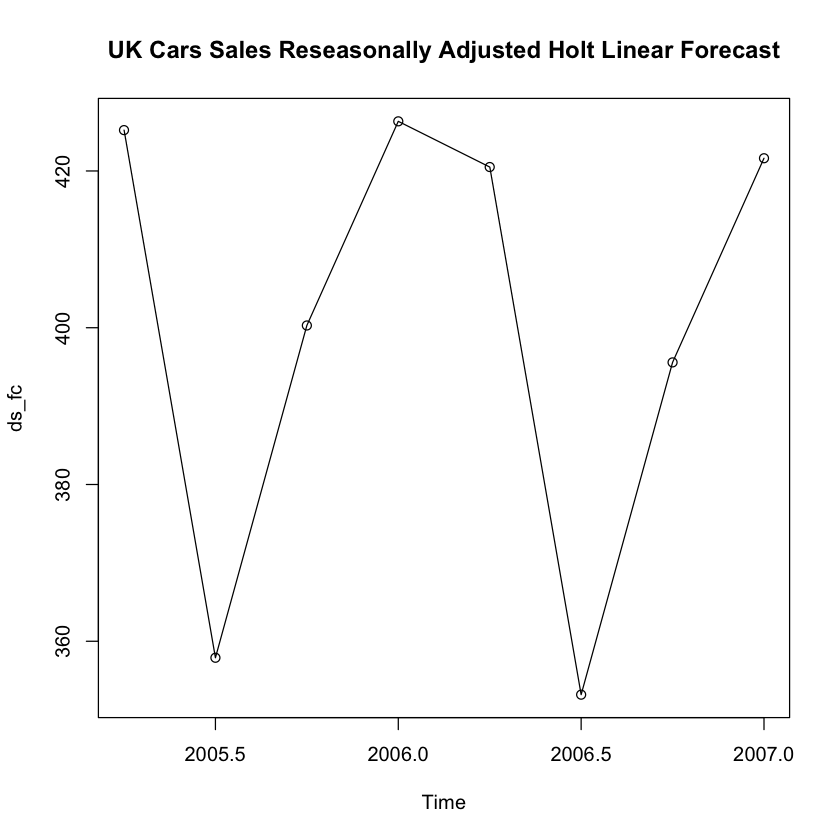

In [12]:
plot(ds_fc, type="o", main="UK Cars Sales Reseasonally Adjusted Holt Linear Forecast")

## 2f)

I think it looks reasonable. The seasonplot of the previous 15 years shows that Q1 is big, Q2 goes down just a bit, Q3 goes down drastically, and Q4 doesn't quite come back up to Q1/Q2 levels.
This new plot of the forecast has that same seasonality.

## 2g) ETS

I take this question to mean do an ETS on the original Seasonally Adjusted data to let it find the optimal model. If I don't do the ETS against the seasonally adjusted data, then comparing the Holt against seasonally adjusted data to an ETS of the full data set doesn't seem to be comparing apples to apples

This ETS is telling me that SES is the optimal model (No Trend, No Seasonality) with Additive Error. 

## ETS against Seasonally Adjusted Data

In [13]:
holt_sa_ets = ets(ds_sa)
holt_sa_ets_forecast = forecast(holt_sa_ets, h=8)
summary(holt_sa_ets)

ETS(A,N,N) 

Call:
 ets(y = ds_sa) 

  Smoothing parameters:
    alpha = 0.6167 

  Initial states:
    l = 318.3843 

  sigma:  25.2279

     AIC     AICc      BIC 
1267.711 1267.821 1273.166 

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.259939 25.22788 20.21963 -0.1384294 6.508415 0.6589481
                   ACF1
Training set 0.02657539


## Making Sure I understand results of ETS

Since I believe the ETS is telling me I have an SES model, I want to make sure I get the same results as the ETS when I run my own SES model. It looks like I do get really close alpha results and exact same RMSE results.

In [14]:
set.seed(1)

summary(ets(ds_sa))
holt_sa_ets_forecast
"-----------------------------------------------"
summary(ses(ds_sa))


ETS(A,N,N) 

Call:
 ets(y = ds_sa) 

  Smoothing parameters:
    alpha = 0.6167 

  Initial states:
    l = 318.3843 

  sigma:  25.2279

     AIC     AICc      BIC 
1267.711 1267.821 1273.166 

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.259939 25.22788 20.21963 -0.1384294 6.508415 0.6589481
                   ACF1
Training set 0.02657539


        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2005 Q2       406.1915 373.8607 438.5224 356.7458 455.6373
2005 Q3       406.1915 368.2063 444.1767 348.0982 464.2849
2005 Q4       406.1915 363.2909 449.0922 340.5806 471.8025
2006 Q1       406.1915 358.8834 453.4997 333.8400 478.5431
2006 Q2       406.1915 354.8529 457.5302 327.6759 484.7072
2006 Q3       406.1915 351.1166 461.2665 321.9617 490.4214
2006 Q4       406.1915 347.6182 464.7649 316.6113 495.7718
2007 Q1       406.1915 344.3172 468.0659 311.5629 500.8202

[1] "-----------------------------------------------"


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(x = ds_sa) 

  Smoothing parameters:
    alpha = 0.6169 

  Initial states:
    l = 318.3564 

  sigma:  25.2279

     AIC     AICc      BIC 
1267.711 1267.821 1273.166 

Error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.259903 25.22788 20.21955 -0.1383556 6.508426 0.6589453
                   ACF1
Training set 0.02639917

Forecasts:
        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2005 Q2       406.1904 373.8596 438.5213 356.7447 455.6362
2005 Q3       406.1904 368.2017 444.1791 348.0917 464.2891
2005 Q4       406.1904 363.2836 449.0973 340.5700 471.8108
2006 Q1       406.1904 358.8739 453.5070 333.8260 478.5549
2006 Q2       406.1904 354.8415 457.5394 327.6590 484.7219
2006 Q3       406.1904 351.1035 461.2774 321.9422 490.4387
2006 Q4       406.1904 347.6035 464.7774 316.5894 495.7915
2007 Q1       406.1904 344.3011 

## ETS against full data set

In [15]:
holt_ds_ets = ets(ds_full)
holt_ds_ets_forecast = forecast(holt_ds_ets, h=8)
summary(holt_ds_ets)

ETS(A,N,A) 

Call:
 ets(y = ds_full) 

  Smoothing parameters:
    alpha = 0.6267 
    gamma = 1e-04 

  Initial states:
    l = 313.0916 
    s=-1.1271 -44.606 21.5553 24.1778

  sigma:  25.2579

     AIC     AICc      BIC 
1275.980 1276.773 1292.345 

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.324962 25.25792 20.12508 -0.1634983 6.609629 0.6558666
                   ACF1
Training set 0.01909295


## 2h) RMSE Compare

* The RMSE of the Holt Linear = 28.70238
* The RMSE of the ETS against Seasonally Adjusted = 20.21963
* The RMSE of the ETS against Full Data Set = 25.25792

I explain this as the ETS is supposed to be finding the best fit.

## 2i) Plot future

The result from the ETS (blue line) looks silly. Since it is an SES model it is just straight line. At least the Holt Linear Model has a slope to it showing some trend. The fitted values are very much the same, so I don't understand why the ETS would think that no trend is in there. I get why it didn't find any seasonality, because we adjusted the data for seasonality.

Green Line is the ETS against the original dataset. It is being reported as Additive Seasonality and No Trend, which I don't find a similar model description for in our definitions from the text. The forecast looks like it takes on a similar shape of our forecast from 2f.

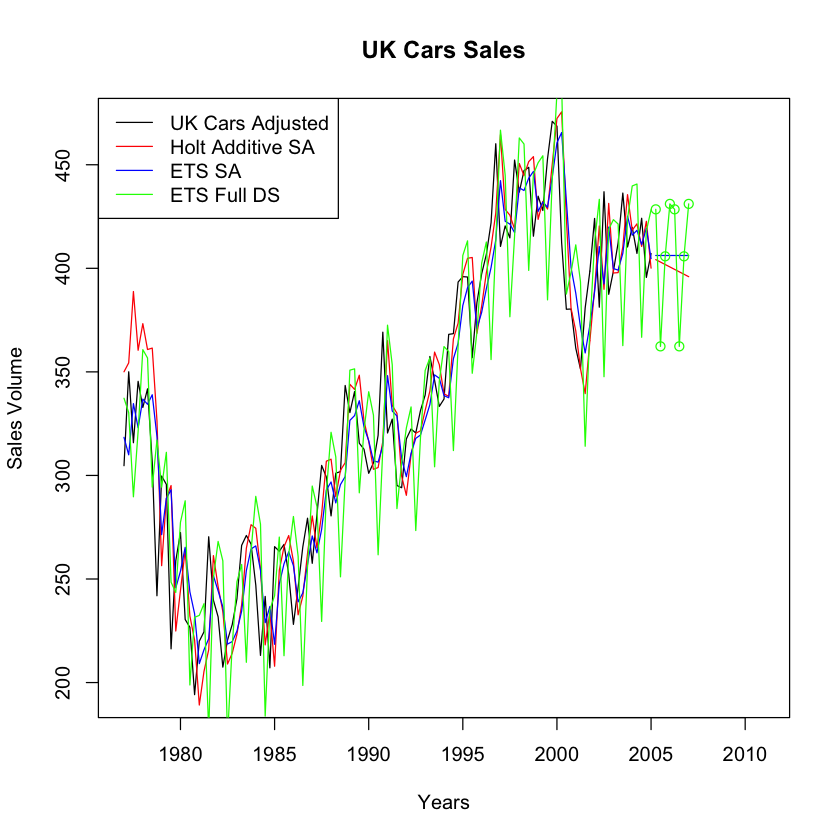

In [16]:
plot(ds_sa, xlim=c(start(ukcars)[1], end(ukcars)[1]+6), main="UK Cars Sales", ylab="Sales Volume", xlab="Years")

# Plot the fitted values to original
lines(fitted(holt_lin), col="red")
# Plot the forecasted values
lines(holt_lin$mean, col="red")

lines(fitted(holt_sa_ets_forecast), col="blue")
lines(holt_sa_ets_forecast$mean, col="blue")

lines(fitted(holt_ds_ets_forecast), col="green")
lines(holt_ds_ets_forecast$mean, col="green", type="o")

legend("topleft"
       , lty=1
       , col=c("black", "red", "blue", "green")
       , c("UK Cars Adjusted", "Holt Additive SA", "ETS SA", "ETS Full DS")
       )

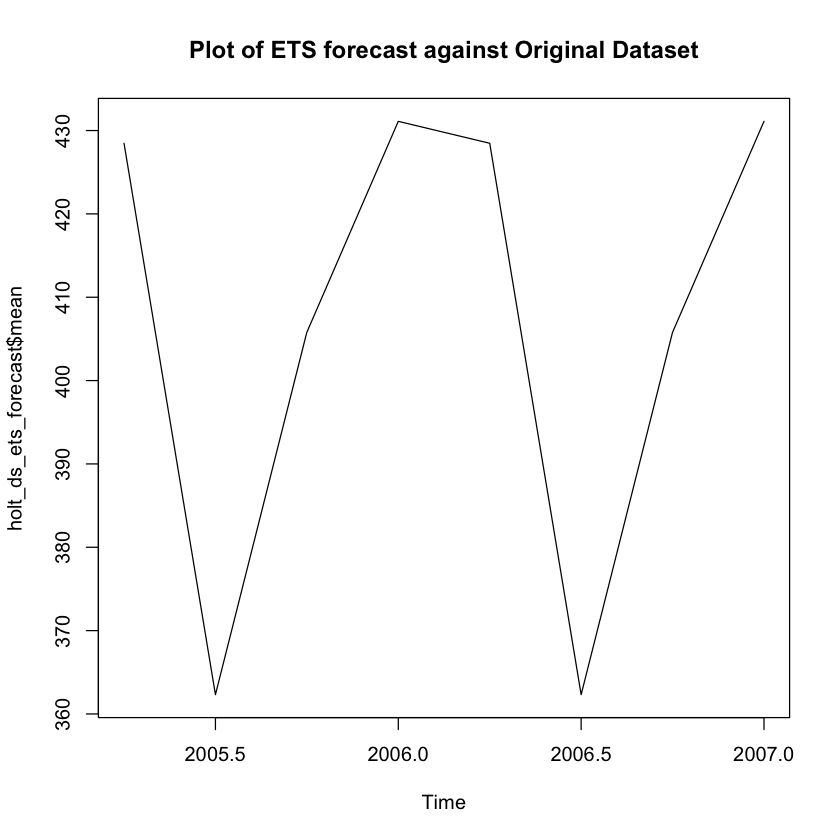

In [17]:
plot(holt_ds_ets_forecast$mean, main="Plot of ETS forecast against Original Dataset")